In this file, Model uses ["INNER_TPRT_1", "EXTN_TPRT", "INNER_HMDT_1", "DWP_TPRT"], which mean inner temperature, external temperature, inner humidity, dew point temperature.
- Input: "EXTN_TPRT", "INNER_HMDT_1", "DWP_TPRT"
- Target(output): INNER_TPRT_1

In [1]:

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler

np.random.seed(42)

In [2]:
# columns used frequently
"EXTN_TPRT", "DWP_TPRT", "EXTN_SRQT", 
"INNER_HMDT_1", "INNER_HMDT_2",
"INNER_TPRT_1", "INNER_TPRT_2"

('INNER_TPRT_1', 'INNER_TPRT_2')

# define useful functions

In [3]:
from util.log import describe_df

In [4]:
def sliding_windows(data, seq_length, x_cols, y_cols):
    x = []
    y = []

    for i in range(len(data)-seq_length-1):
        _x = data[i:(i+seq_length), x_cols]
        _y = data[i+seq_length, y_cols]
        x.append(_x)
        y.append(_y)

    return np.array(x),np.array(y)

def preprocess(df, x_cols, y_cols):
    training_data =df.to_numpy()

    seq_length = 4
    print(training_data.shape)
    x, y = sliding_windows(training_data, seq_length, x_cols, y_cols)
    train_size = int(len(y) * 0.8)
    test_size = len(y) - train_size

    print(x.shape, y.shape)

    dataX = Variable(torch.Tensor(np.array(x)))
    dataY = Variable(torch.Tensor(np.array(y)))

    trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
    trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

    testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
    testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

    print(trainX.shape, trainY.shape, testX.shape, testY.shape, sep="\n")
    print(trainX[0], trainY[0])
    print(trainX[1], trainY[1])
    print((trainX[1][-1]==trainY[0]).all())

    return train_size, dataX, dataY, trainX, trainY, testX, testY 

In [6]:
from util.model import LSTM

def train(trainX, trainY, epoch=None, hidden_size=64):
    num_epochs = epoch if epoch else 2000
    learning_rate = 0.01

    input_size = trainX.shape[-1]
    hidden_size = hidden_size
    num_layers = 1

    num_classes = trainY.shape[-1] # output_size

    lstm = LSTM(num_classes, input_size, hidden_size, num_layers)

    criterion = torch.nn.MSELoss()    # mean-squared error for regression
    optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)

    # Train the model
    for epoch in range(num_epochs):
        outputs = lstm(trainX)
        optimizer.zero_grad()
        
        # obtain the loss function
        loss = criterion(outputs, trainY)
        
        loss.backward()
        
        optimizer.step()
        if epoch % 100 == 0:
            print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))
    
    return lstm

In [7]:
from util.log import save_model, regression_results

def eval(lstm, X, Y, train_size=None):
    lstm.eval()
    train_predict = lstm(X)
    print("X dataset shape & prediction shape:", X.shape, train_predict.shape)

    predict = train_predict.data.numpy()
    Y_plot = Y.data.numpy()

    # temp = np.empty((X.shape[0], X.shape[-1]+Y.shape[-1]))
    # temp[:,]
    # predict = sc.inverse_transform(predict)
    # Y_plot = sc.inverse_transform(Y_plot)

    regression_results(Y_plot, predict)

    plt.figure(figsize=(15, 5)) 
    if train_size:
        plt.axvline(x=train_size, c='r', linestyle='--')
    plt.plot(Y_plot)
    plt.plot(predict, linestyle='dotted')
    plt.suptitle('Time-Series Prediction')
    plt.show()

# 5min step

# Only One LSTM

          EXTN_TPRT      DWP_TPRT  INNER_TPRT_1  INNER_HMDT_1
count  48384.000000  48384.000000  48384.000000  48384.000000
mean       9.895658     15.302369     18.848890     81.585038
std        8.578428      3.269531      4.684028     11.649284
min      -12.300000      3.670000     12.000000     33.270000
25%        2.930000     12.770000     14.870000     73.830000
50%        9.800000     14.730000     17.530000     85.970000
75%       16.870000     17.330000     21.800000     90.100000
max       31.730000     28.170000     35.400000     99.100000


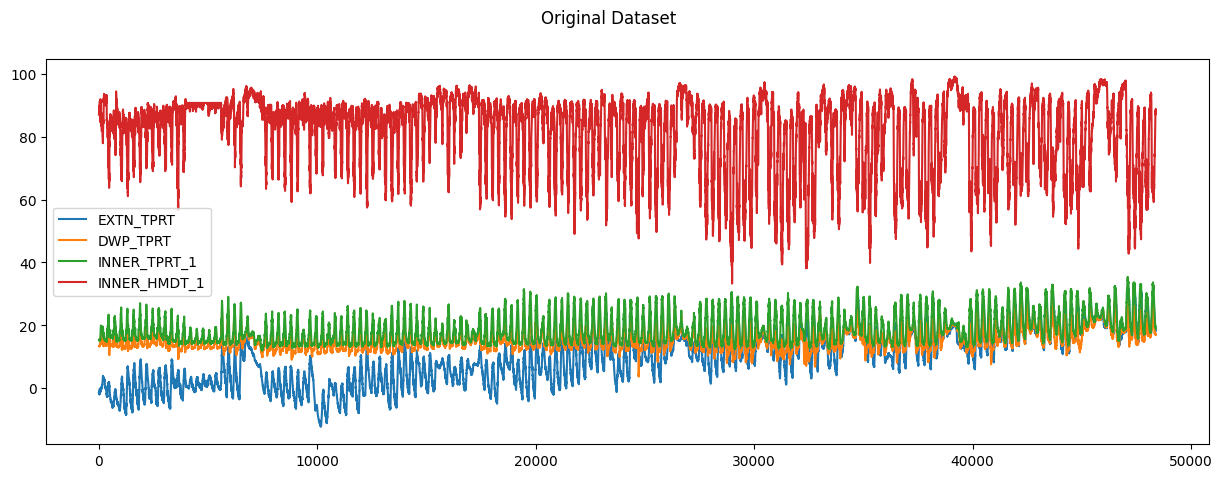

In [5]:
raw_df = pd.read_csv("merged.csv", usecols=["INNER_TPRT_1", "EXTN_TPRT", "INNER_HMDT_1", "DWP_TPRT"])
df = raw_df #[:5000]
# df["MSRM_DT"] = (pd.to_datetime(df["MSRM_DT"]) - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')

describe_df(df)

In [6]:
df.head()

,EXTN_TPRT,DWP_TPRT,INNER_TPRT_1,INNER_HMDT_1
0,-1.35,13.35,15.45,87.05
1,-1.30,13.25,15.30,87.45
2,-1.50,13.40,15.25,88.40
3,-1.55,13.40,15.30,87.95
4,-1.40,13.40,15.35,87.95


In [22]:
x_cols = [0,1, 3]
y_cols = [2]
train_size, dataX, dataY, trainX, trainY, testX, testY = preprocess(df, x_cols, y_cols)

(48384, 4)
(48379, 4, 3) (48379, 1)
torch.Size([38703, 4, 3])
torch.Size([38703, 1])
torch.Size([9676, 4, 3])
torch.Size([9676, 1])
tensor([[-1.3500, 13.3500, 87.0500],
        [-1.3000, 13.2500, 87.4500],
        [-1.5000, 13.4000, 88.4000],
        [-1.5500, 13.4000, 87.9500]]) tensor([15.3500])
tensor([[-1.3000, 13.2500, 87.4500],
        [-1.5000, 13.4000, 88.4000],
        [-1.5500, 13.4000, 87.9500],
        [-1.4000, 13.4000, 87.9500]]) tensor([15.4000])
tensor(False)


In [23]:
lstm = train(trainX, trainY)

Epoch: 0, loss: 347.24228
Epoch: 100, loss: 17.87820
Epoch: 200, loss: 13.16040
Epoch: 300, loss: 7.80793
Epoch: 400, loss: 0.27039
Epoch: 500, loss: 0.23489
Epoch: 600, loss: 0.15248
Epoch: 700, loss: 0.15358
Epoch: 800, loss: 0.11647
Epoch: 900, loss: 0.20383
Epoch: 1000, loss: 0.10464
Epoch: 1100, loss: 0.10076
Epoch: 1200, loss: 0.10552
Epoch: 1300, loss: 0.09826
Epoch: 1400, loss: 0.08973
Epoch: 1500, loss: 0.11201
Epoch: 1600, loss: 0.13306
Epoch: 1700, loss: 0.15989
Epoch: 1800, loss: 0.08222
Epoch: 1900, loss: 0.08210


In [24]:
save_model(lstm)

parameter size: 0.194584MB
model dict size: 872


X dataset shape & prediction shape: torch.Size([48379, 4, 3]) torch.Size([48379, 1])
explained_variance:  0.9944
mean_squared_log_error:  0.0002
r2:  0.9939
MAE:  0.2218
MSE:  0.1349
RMSE:  0.3673


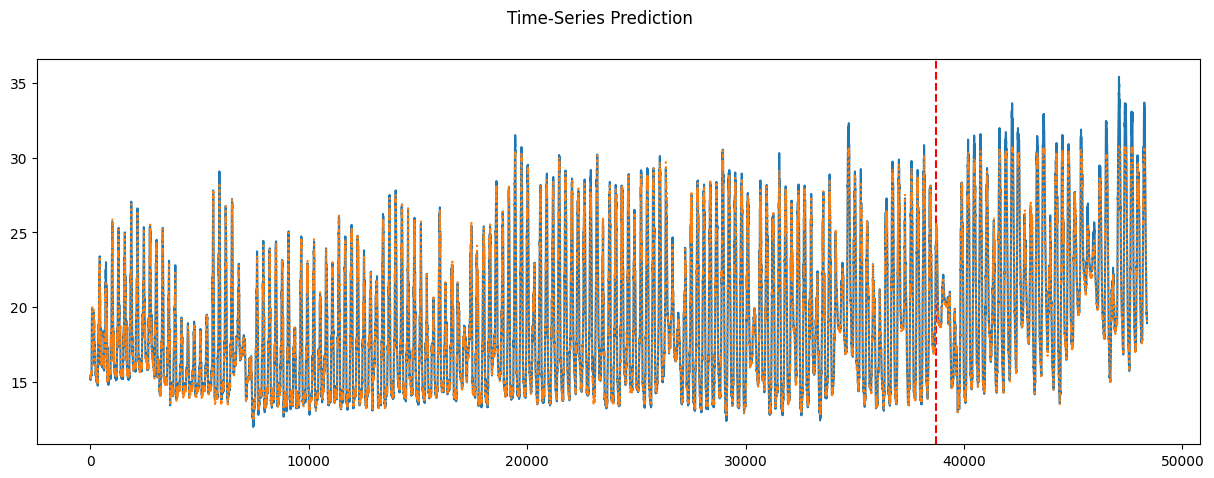

In [25]:
eval(lstm, dataX, dataY, train_size)

X dataset shape & prediction shape: torch.Size([9676, 4, 3]) torch.Size([9676, 1])
explained_variance:  0.9899
mean_squared_log_error:  0.0004
r2:  0.9873
MAE:  0.3282
MSE:  0.3337
RMSE:  0.5776


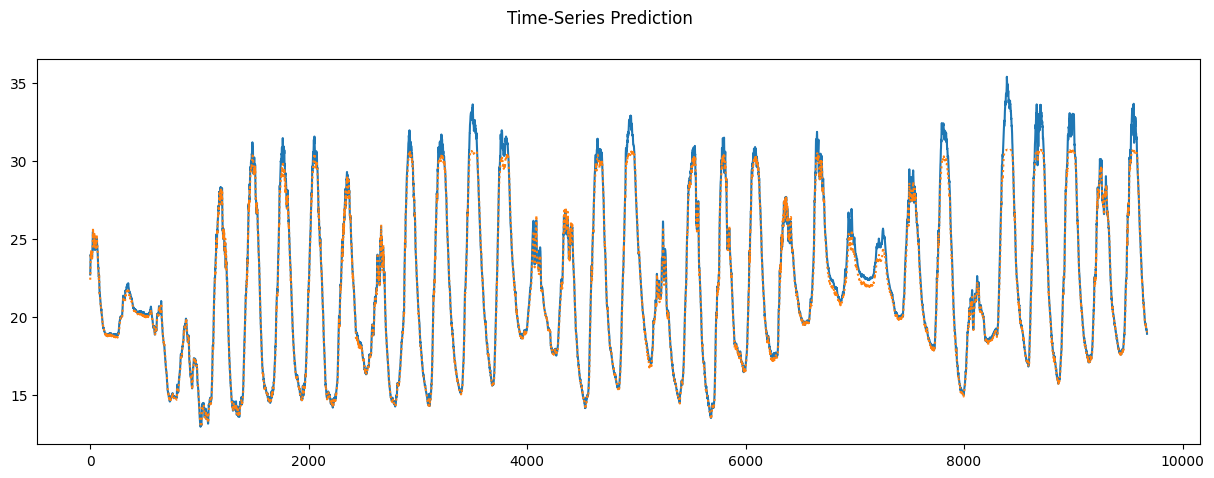

In [26]:
eval(lstm, testX, testY)

# Double Layer LSTM

Remove dropout, because dropout is useless when num_layer is 1

In [27]:
from util.model import DoubleLayerLSTM

In [28]:
LSTM=DoubleLayerLSTM


In [29]:
lstm = train(trainX, trainY)

Epoch: 0, loss: 341.36087
Epoch: 100, loss: 17.87326
Epoch: 200, loss: 17.86996
Epoch: 300, loss: 17.86946
Epoch: 400, loss: 0.66620
Epoch: 500, loss: 0.29444
Epoch: 600, loss: 0.25502
Epoch: 700, loss: 0.18792
Epoch: 800, loss: 0.16452
Epoch: 900, loss: 0.15127
Epoch: 1000, loss: 0.13412
Epoch: 1100, loss: 0.12399
Epoch: 1200, loss: 0.36681
Epoch: 1300, loss: 0.11570
Epoch: 1400, loss: 0.12132
Epoch: 1500, loss: 0.10275
Epoch: 1600, loss: 0.10746
Epoch: 1700, loss: 0.10233
Epoch: 1800, loss: 0.08990
Epoch: 1900, loss: 0.13594


X dataset shape & prediction shape: torch.Size([48379, 4, 3]) torch.Size([48379, 1])
explained_variance:  0.9943
mean_squared_log_error:  0.0002
r2:  0.9941
MAE:  0.2309
MSE:  0.1301
RMSE:  0.3607


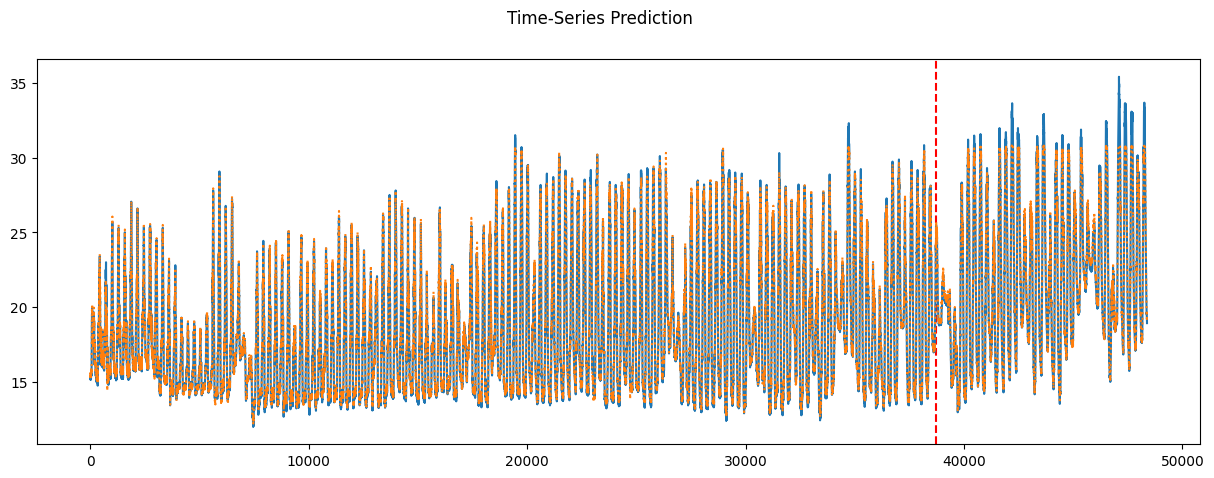

In [30]:
eval(lstm, dataX, dataY, train_size)

X dataset shape & prediction shape: torch.Size([9676, 4, 3]) torch.Size([9676, 1])
explained_variance:  0.9895
mean_squared_log_error:  0.0003
r2:  0.9895
MAE:  0.3061
MSE:  0.275
RMSE:  0.5244


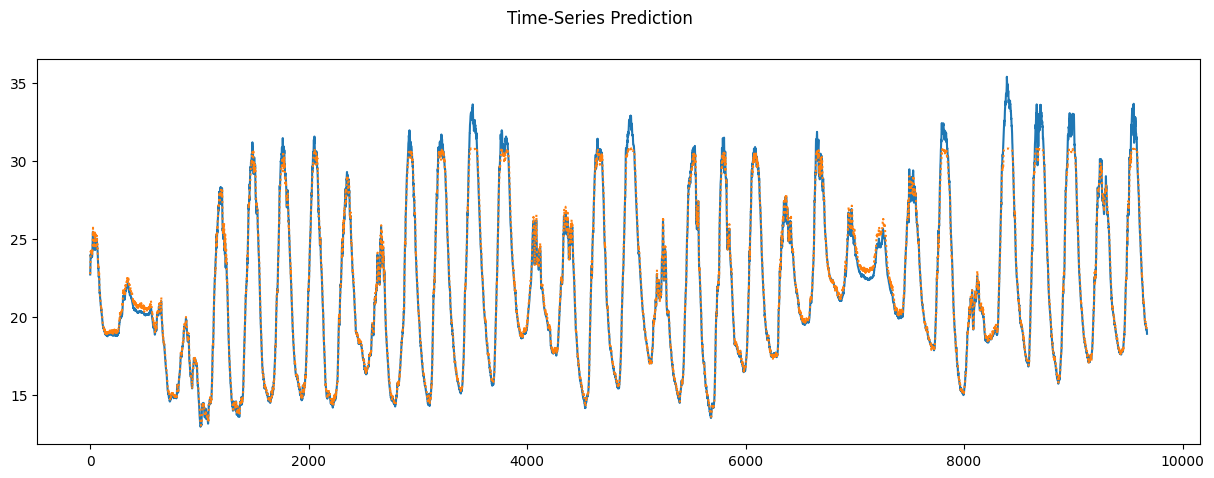

In [31]:
eval(lstm, testX, testY)